# Demo of Anisotropic Noise Problem

In [190]:
from typing import List, Any, Tuple, Callable, Union
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

I generate vectors of random numbers within different ranges to use as "samples" for noise calculation. Notice the "shape" of the input vector, which has small variance on the edges and high variance in the middle. I intentionally made the shape easy to recognize and non-symmetric to demonstrate how the noise outputs are not in the correct order.

You can change sample_once to change the vectors used.

In [191]:
def sample_once() -> np.ndarray:
    """
    Mock query function that returns a vector for debugging composed of random integers
    sampled from different ranges.
    """
    a = np.random.randint(0, 1)
    b = np.random.randint(0, 10)
    c = np.random.randint(0, 100)
    d = np.random.randint(0, 50)
    e = np.random.randint(0, 1)
    return np.array([a, b, c, d, e])

sample_once()

array([ 0,  2, 60, 32,  0])

Here's a visualization of the "shape" of the input vector, produced by averaging 1000 samples.

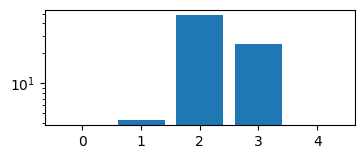

In [192]:
fig, ax = plt.subplots(figsize=(4, 1.5))
avg_sample = np.mean([sample_once() for _ in range(1000)], axis=0)
plt.bar(range(len(avg_sample)), avg_sample, log=True)
plt.show()

This is the noise calculation method from pacdb/main.py, copied here for easy manipulation. If you change the function in this cell below and then re-run the cell, the function should be redefined, allowing you to change it iteratively and see the effects.

In [193]:
def estimate_hybrid_noise_static(
        sample_once: Callable[[], np.ndarray],
        max_mi: float = 1./4,
        anisotropic: bool = False,
        eta: float = 0.05
        ) -> Tuple[List[float], List[Any]]:
    

    # Use the identity matrix for our projection matrix
    dimensions = len(sample_once())
    proj_matrix: np.ndarray = np.eye(dimensions)

    # If no projection matrix is supplied, compute one
    BASIS_SAMPLES = 500
    if anisotropic:
        # 1. COLLECT SAMPLES
        outputs: List[np.ndarray] = [sample_once() for _ in range(BASIS_SAMPLES)]

        # 2. COVARIANCE MATRIX
        y_cov: np.ndarray = np.atleast_2d(np.cov(np.array(outputs).T))
        # y_cov_idx = np.argsort(np.diag(y_cov))[::-1]  # <- speculative fix?

        # 3. PROJECTION MATRIX (from SVD of covariance matrix)
        u, eigs, u_t = np.linalg.svd(y_cov)
        proj_matrix = u
        # proj_matrix = proj_matrix[y_cov_idx]  # <- speculative fix?
    else:
        proj_matrix = np.eye(dimensions)

    # projected samples used to estimate variance in each basis direction
    # est_y[i] is a list of magnitudes of the outputs in the i-th basis direction
    est_y: List[List[np.ndarray]] = [[] for _ in range(dimensions)]
    prev_ests: List[Union[float, np.floating[Any]]] = [np.inf for _ in range(dimensions)] # only to measure change per iteration for convergence

    converged = False
    curr_trial = 0

    while not converged:
        output: np.ndarray = sample_once()
        assert len(output) == dimensions

        # Compute the magnitude of the output in each of the basis directions, update the estimate lists
        for i in range(len(output)):
            if anisotropic:
                est_y[i].append(np.matmul(proj_matrix[i].T, output.T)) # transform back to original basis before storing
            else:
                est_y[i].append(output[i])

        # Every 10 trials, check for convergence
        if curr_trial % 10 == 0:
            # If all dimensions' variance estimates changed by less than eta, we have converged
            if all(abs(np.var(est_y[i]) - prev_ests[i]) <= eta for i in range(dimensions)):
                converged = True
            else:
                # we have not converged, so update the previous estimates and continue
                prev_ests = [np.var(est_y[i]) for i in range(dimensions)]
        curr_trial += 1

    # Now that we have converged, get the variance in each basis direction
    fin_var: List[np.floating[Any]] = [np.var(est_y[i]) for i in range(dimensions)]
    # and the mean in each basis direction
    fin_mean: List[np.floating[Any]] = [np.mean(est_y[i]) for i in range(dimensions)]

    sqrt_total_var = sum(fin_var)**0.5

    noise: List[float] = [np.inf for _ in range(dimensions)]
    for i in range(dimensions):
        noise[i] = float(1./(2*max_mi) * fin_var[i]**0.5 * sqrt_total_var)

    return noise, [sqrt_total_var, fin_var, fin_mean]

The (first) output of the method is the variances of normal distributions from which the noise to add should be sampled.

In [194]:
noise, stats = estimate_hybrid_noise_static(sample_once, max_mi=1./4, anisotropic=True, eta=0.05)
noise

[0.0,
 1867.1557532573224,
 10.012343263193937,
 184.9884863829233,
 953.7732105198924]

Visualization of the "shape" of the noise.

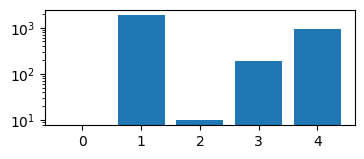

In [195]:
fig, ax = plt.subplots(figsize=(4, 1.5))
plt.bar(range(len(noise)), noise, log=True)
plt.show()